In [60]:
!pip install torch-summary

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms, models
from torchvision.models.resnet import BasicBlock, ResNet
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

In [85]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class CustomModel(nn.Module):
    def __init__(self, block, num_blocks, num_classes=25):
        super(CustomModel, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = nn.AdaptiveAvgPool2d((1, 1))(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [83]:
# take things to device the entire models things so thattheres no conflict between variables in devices

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)     


In [84]:
# Viem Model architecture
from torchsummary import summary
model = to_device(CustomModel(BasicBlock, [2, 2, 2, 2], num_classes=25),device)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

In [86]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((416,416)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        ToTensor(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4731, 0.4819, 0.4018], std=[0.1925, 0.1915, 0.1963])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4706, 0.4802, 0.4020], std=[0.1907, 0.1898, 0.1950])
    ]),
}

In [87]:
# Data loaded into the required part

data_dir = '/kaggle/input/seen-dataset-12-class/Seen Datasets'
image_datasets = {x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}
data_loaders = {x: data.DataLoader(image_datasets[x], batch_size=batch_size,
                                   shuffle=True, num_workers=8, pin_memory=True)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


In [88]:
# Loss and optimizer Intitalize

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=initial_lr,steps_per_epoch=len(data_loaders['train']), epochs=num_epochs)


In [89]:
# Hyperparameters and Device Initialization 
num_classes = 25
batch_size = 64
num_epochs = 50
grad_clip=0.1
initial_lr = 0.001
weight_decay = 1e-4
dropout_rate = 0.5
patience = 10 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [91]:
# Setup parameters required later for tracking 
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Training process not a fucntion
best_acc = 0.0
early_stop_counter = 0
best_model_wts = None
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(data_loaders[phase], desc=f"{phase} - Epoch {epoch+1}"):
            inputs = inputs.to(device, non_blocking=True) #Cuda or CPU
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
#               Removed  
#                 if grad_clip: 
#                     nn.utils.clip_grad_value_(model.parameters(), grad_clip)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()
            epoch_train_loss = running_loss / dataset_sizes['train']
            epoch_train_corrects = running_corrects.double() / dataset_sizes['train']
        else:
            epoch_val_loss = running_loss / dataset_sizes['val']
            epoch_val_corrects = running_corrects.double() / dataset_sizes['val']

    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_corrects.item())
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_corrects.item())

    print(f'Train Loss: {epoch_train_loss:.4f} Accuracy: {epoch_train_corrects:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f} Accuracy: {epoch_val_corrects:.4f}')

    if epoch_val_corrects > best_acc:
        best_acc = epoch_val_corrects
        best_model_wts = model.state_dict().copy()
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping done")
        model.load_state_dict(best_model_wts)
        break

print('Best Validation Accuracy: {:4f}'.format(best_acc))

# Load best model weights
if best_model_wts:
    model.load_state_dict(best_model_wts)
# Better if saved model each time we got better accuracy but takes too long time
# Save the entire model
torch.save(model.state_dict(), 'model.pt')
print("Model saved")

Epoch 0/49


val - Epoch 1: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


Train Loss: 2.4209 Accuracy: 0.2863
Validation Loss: 2.1073 Accuracy: 0.3727
Epoch 1/49


val - Epoch 2: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Train Loss: 2.2422 Accuracy: 0.3363
Validation Loss: 1.9708 Accuracy: 0.4159
Epoch 2/49


val - Epoch 3: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 2.1295 Accuracy: 0.3685
Validation Loss: 1.6842 Accuracy: 0.4933
Epoch 3/49


val - Epoch 4: 100%|██████████| 118/118 [00:44<00:00,  2.62it/s]


Train Loss: 1.9976 Accuracy: 0.4052
Validation Loss: 1.6017 Accuracy: 0.5213
Epoch 4/49


val - Epoch 5: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Train Loss: 1.9109 Accuracy: 0.4338
Validation Loss: 1.4513 Accuracy: 0.5620
Epoch 5/49


val - Epoch 6: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


Train Loss: 1.8087 Accuracy: 0.4618
Validation Loss: 1.3132 Accuracy: 0.5956
Epoch 6/49


val - Epoch 7: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 1.7378 Accuracy: 0.4838
Validation Loss: 1.3343 Accuracy: 0.5921
Epoch 7/49


val - Epoch 8: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 1.6841 Accuracy: 0.5012
Validation Loss: 1.1567 Accuracy: 0.6495
Epoch 8/49


val - Epoch 9: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Train Loss: 1.6153 Accuracy: 0.5178
Validation Loss: 1.1978 Accuracy: 0.6447
Epoch 9/49


val - Epoch 10: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s]


Train Loss: 1.5690 Accuracy: 0.5339
Validation Loss: 1.1333 Accuracy: 0.6604
Epoch 10/49


val - Epoch 11: 100%|██████████| 118/118 [00:44<00:00,  2.65it/s]


Train Loss: 1.5228 Accuracy: 0.5494
Validation Loss: 0.9901 Accuracy: 0.7093
Epoch 11/49


val - Epoch 12: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 1.4738 Accuracy: 0.5612
Validation Loss: 0.9057 Accuracy: 0.7252
Epoch 12/49


val - Epoch 13: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


Train Loss: 1.4379 Accuracy: 0.5698
Validation Loss: 0.9440 Accuracy: 0.7161
Epoch 13/49


val - Epoch 14: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s]


Train Loss: 1.4065 Accuracy: 0.5804
Validation Loss: 0.8841 Accuracy: 0.7339
Epoch 14/49


val - Epoch 15: 100%|██████████| 118/118 [00:44<00:00,  2.67it/s]


Train Loss: 1.3782 Accuracy: 0.5857
Validation Loss: 0.8351 Accuracy: 0.7443
Epoch 15/49


val - Epoch 16: 100%|██████████| 118/118 [00:44<00:00,  2.65it/s]


Train Loss: 1.3374 Accuracy: 0.5997
Validation Loss: 0.8884 Accuracy: 0.7381
Epoch 16/49


val - Epoch 17: 100%|██████████| 118/118 [00:47<00:00,  2.49it/s]


Train Loss: 1.3128 Accuracy: 0.6076
Validation Loss: 0.7900 Accuracy: 0.7600
Epoch 17/49


val - Epoch 18: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]


Train Loss: 1.2849 Accuracy: 0.6203
Validation Loss: 0.8310 Accuracy: 0.7425
Epoch 18/49


val - Epoch 19: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 1.2480 Accuracy: 0.6285
Validation Loss: 0.7744 Accuracy: 0.7644
Epoch 19/49


val - Epoch 20: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Train Loss: 1.2431 Accuracy: 0.6284
Validation Loss: 0.7277 Accuracy: 0.7813
Epoch 20/49


val - Epoch 21: 100%|██████████| 118/118 [00:45<00:00,  2.58it/s]


Train Loss: 1.2145 Accuracy: 0.6388
Validation Loss: 0.6680 Accuracy: 0.8043
Epoch 21/49


val - Epoch 22: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Train Loss: 1.2038 Accuracy: 0.6438
Validation Loss: 0.7187 Accuracy: 0.7819
Epoch 22/49


val - Epoch 23: 100%|██████████| 118/118 [00:46<00:00,  2.55it/s]


Train Loss: 1.1681 Accuracy: 0.6524
Validation Loss: 0.6403 Accuracy: 0.8077
Epoch 23/49


val - Epoch 24: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Train Loss: 1.1635 Accuracy: 0.6520
Validation Loss: 0.6011 Accuracy: 0.8233
Epoch 24/49


val - Epoch 25: 100%|██████████| 118/118 [00:46<00:00,  2.52it/s]


Train Loss: 1.1073 Accuracy: 0.6708
Validation Loss: 0.6007 Accuracy: 0.8219
Epoch 25/49


val - Epoch 26: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Train Loss: 1.1040 Accuracy: 0.6691
Validation Loss: 0.6192 Accuracy: 0.8131
Epoch 26/49


val - Epoch 27: 100%|██████████| 118/118 [00:46<00:00,  2.56it/s]


Train Loss: 1.0933 Accuracy: 0.6725
Validation Loss: 0.6571 Accuracy: 0.8023
Epoch 27/49


val - Epoch 28: 100%|██████████| 118/118 [00:46<00:00,  2.53it/s]


Train Loss: 1.0679 Accuracy: 0.6802
Validation Loss: 0.5921 Accuracy: 0.8264
Epoch 28/49


val - Epoch 29: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Train Loss: 1.0644 Accuracy: 0.6823
Validation Loss: 0.5476 Accuracy: 0.8416
Epoch 29/49


val - Epoch 30: 100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


Train Loss: 1.0369 Accuracy: 0.6932
Validation Loss: 0.5723 Accuracy: 0.8271
Epoch 30/49


val - Epoch 31: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Train Loss: 1.0471 Accuracy: 0.6870
Validation Loss: 0.5339 Accuracy: 0.8427
Epoch 31/49


val - Epoch 32: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


Train Loss: 1.0222 Accuracy: 0.6960
Validation Loss: 0.5886 Accuracy: 0.8243
Epoch 32/49


val - Epoch 33: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]


Train Loss: 1.0029 Accuracy: 0.7030
Validation Loss: 0.4962 Accuracy: 0.8501
Epoch 33/49


val - Epoch 34: 100%|██████████| 118/118 [00:44<00:00,  2.62it/s]


Train Loss: 0.9805 Accuracy: 0.7043
Validation Loss: 0.5067 Accuracy: 0.8479
Epoch 34/49


val - Epoch 35: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]


Train Loss: 0.9879 Accuracy: 0.7024
Validation Loss: 0.4595 Accuracy: 0.8643
Epoch 35/49


val - Epoch 36: 100%|██████████| 118/118 [00:44<00:00,  2.67it/s]


Train Loss: 0.9803 Accuracy: 0.7069
Validation Loss: 0.4766 Accuracy: 0.8584
Epoch 36/49


val - Epoch 37: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


Train Loss: 0.9489 Accuracy: 0.7163
Validation Loss: 0.4534 Accuracy: 0.8653
Epoch 37/49


val - Epoch 38: 100%|██████████| 118/118 [00:44<00:00,  2.67it/s]


Train Loss: 0.9362 Accuracy: 0.7178
Validation Loss: 0.4612 Accuracy: 0.8596
Epoch 38/49


val - Epoch 39: 100%|██████████| 118/118 [00:44<00:00,  2.68it/s]


Train Loss: 0.9214 Accuracy: 0.7234
Validation Loss: 0.4476 Accuracy: 0.8656
Epoch 39/49


val - Epoch 40: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s]


Train Loss: 0.9171 Accuracy: 0.7233
Validation Loss: 0.4334 Accuracy: 0.8701
Epoch 40/49


val - Epoch 41: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s]


Train Loss: 0.9107 Accuracy: 0.7272
Validation Loss: 0.4777 Accuracy: 0.8544
Epoch 41/49


val - Epoch 42: 100%|██████████| 118/118 [00:43<00:00,  2.71it/s]


Train Loss: 0.8856 Accuracy: 0.7321
Validation Loss: 0.4676 Accuracy: 0.8603
Epoch 42/49


val - Epoch 43: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s]


Train Loss: 0.8965 Accuracy: 0.7294
Validation Loss: 0.4106 Accuracy: 0.8773
Epoch 43/49


val - Epoch 44: 100%|██████████| 118/118 [00:43<00:00,  2.69it/s]


Train Loss: 0.8894 Accuracy: 0.7329
Validation Loss: 0.4225 Accuracy: 0.8760
Epoch 44/49


val - Epoch 45: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]


Train Loss: 0.8720 Accuracy: 0.7374
Validation Loss: 0.3802 Accuracy: 0.8876
Epoch 45/49


val - Epoch 46: 100%|██████████| 118/118 [00:47<00:00,  2.46it/s]


Train Loss: 0.8598 Accuracy: 0.7396
Validation Loss: 0.4035 Accuracy: 0.8807
Epoch 46/49


val - Epoch 47: 100%|██████████| 118/118 [00:46<00:00,  2.51it/s]


Train Loss: 0.8586 Accuracy: 0.7406
Validation Loss: 0.3916 Accuracy: 0.8815
Epoch 47/49


val - Epoch 48: 100%|██████████| 118/118 [00:43<00:00,  2.71it/s]


Train Loss: 0.8505 Accuracy: 0.7428
Validation Loss: 0.3984 Accuracy: 0.8839
Epoch 48/49


val - Epoch 49: 100%|██████████| 118/118 [00:43<00:00,  2.70it/s]


Train Loss: 0.8389 Accuracy: 0.7475
Validation Loss: 0.4050 Accuracy: 0.8772
Epoch 49/49


val - Epoch 50: 100%|██████████| 118/118 [00:44<00:00,  2.66it/s]


Train Loss: 0.8298 Accuracy: 0.7514
Validation Loss: 0.3625 Accuracy: 0.8933
Best Validation Accuracy: 0.893333


PicklingError: Can't pickle <class '__main__.CustomModel'>: it's not the same object as __main__.CustomModel

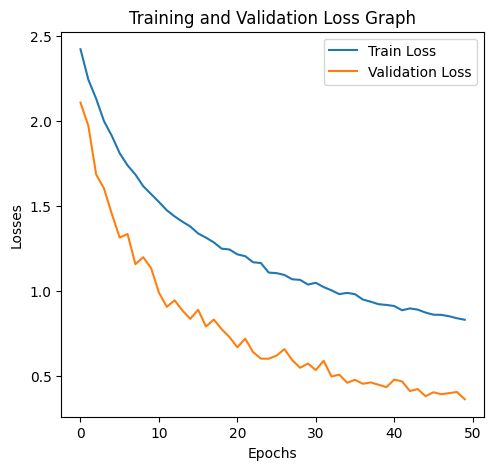

In [100]:
# Plot the training curves
epochs = len(train_loss_history)

plt.figure(figsize=(6, 5))

# Plot the loss

plt.plot(range(epochs), train_loss_history, label='Train Loss')
plt.plot(range(epochs), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training and Validation Loss Graph')
plt.legend()

plt.show()

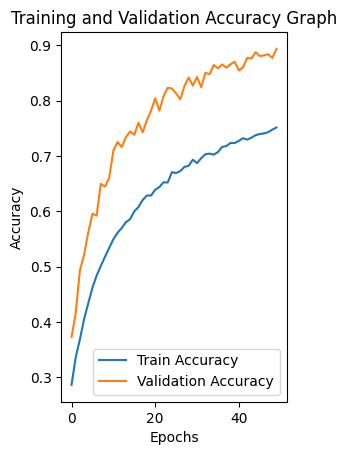

In [101]:
# Plot the accuracy
plt.figure(figsize=(6, 5))

plt.plot(range(epochs), train_acc_history, label='Train Accuracy')
plt.plot(range(epochs), val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Graph')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import numpy as np
import torchvision.transforms as tt

In [ ]:
test_loader=data_loaders['val']
test_dataset=image_datasets['val']

def prediction(test_loader, model, device):
    model.eval()
    list_of_prediction = []
    list_of_probabilities = []
    labels = []
    
    with torch.no_grad():
        for imgs, label in tqdm(test_loader, desc="Processing", leave=False):
            imgs, label = imgs.to(device), label.to(device)

            output = model(imgs)
            if isinstance(output, tuple):
                output = output[0]  

            list_of_probabilities.extend(output.cpu().numpy())
            list_of_prediction.extend(output.argmax(dim=1).cpu().numpy())  
            labels.extend(label.cpu().numpy())  

    return np.array(list_of_prediction), np.array(labels), np.array(list_of_probabilities)

predictions, test_labels, probabilities = prediction(test_loader, model, device)

# REPORT OF PREDICTION
class_names = test_dataset.classes  
report = classification_report(test_labels, predictions, target_names=class_names)
print(report)

# CONFUSION MATRIX 
cm_matrix = confusion_matrix(test_labels, predictions) 
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=class_names)

# CALCULATE ROC-AUC
n_classes = len(class_names)
test_labels_one_hot = label_binarize(test_labels, classes=range(n_classes))

# Calculate ROC-AUC FOR EACH CLASS
roc_auc = roc_auc_score(test_labels_one_hot, probabilities, average='macro', multi_class='ovr')
print(f"Macro-averaged ROC-AUC: {roc_auc:.2f}")

# PLOT CONFUSION MATRIX AND ROC CURVES IN ONE IMAGE
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))  # Increase the figure size

# CONFUSION MATRIX
cm_display.plot(ax=ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xticklabels(class_names, rotation=90)

# ROC CURVE
for i in range(n_classes):
    RocCurveDisplay.from_predictions(test_labels_one_hot[:, i], probabilities[:, i], ax=ax2, name=class_names[i])
ax2.set_title("ROC Curves")

# Plot classification report as text
ax3.axis('off')  
classification_report_str = classification_report(test_labels, predictions, target_names=class_names)
ax3.text(0.5, 0.5, classification_report_str, horizontalalignment='center', verticalalignment='center', fontsize=12, family='monospace')

plt.tight_layout()
plt.show()
